### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.inspection import partial_dependence, plot_partial_dependence

global_rand_state_split = 2571
global_rand_state_xgb = 0

2023-01-26 15:09:41.924014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 15:09:42.541618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/kianoosh/anaconda3/envs/tf/lib/
2023-01-26 15:09:42.541682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/

In [2]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-01-26 15:09:43.251519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2023-01-26 15:09:43.280443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:43.285642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:43.285980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:43.731725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:43.732006: I tensorflow/compiler/xla/stream_executo

In [3]:
# 74.77 for global_rand_state_split = 9, global_rand_state_xgb = 9

Text(0.5, 0, '!!!Ariaaaal')

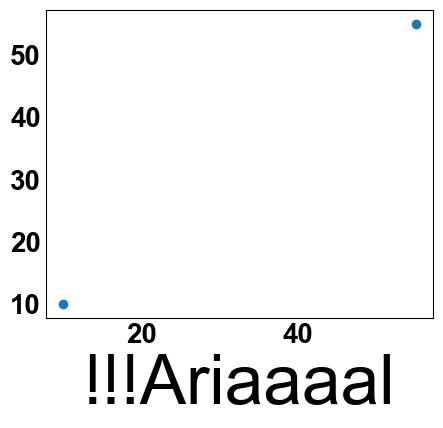

In [4]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [5]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation_90rem.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [6]:
# same value you get from excel
pearsonr(df['charge_density'], df['Graphene_Yield'])[0]**2

0.3798614257174243

PearsonRResult(statistic=0.6163289914626963, pvalue=1.7732718188288054e-19)


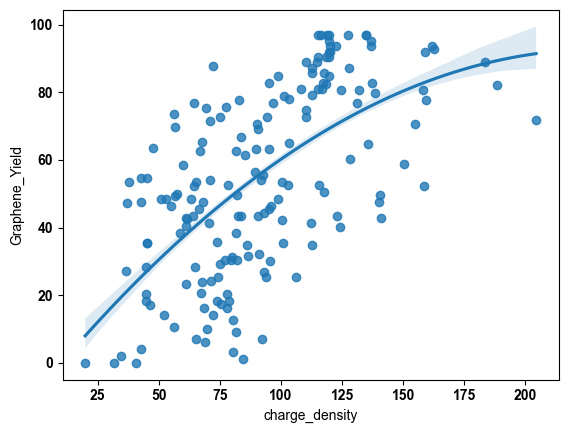

In [7]:
df_capTvolt = df.loc[df['Material']!='C'].copy()
df_capTvolt ['capTvolt'] = df['Cap']*df['Voltage']/1000
sns_cv_gy = sns.regplot(data=df_capTvolt, x='charge_density', y='Graphene_Yield', order=2, ci=50)
print (pearsonr(df_capTvolt ['charge_density'] , df_capTvolt ['Graphene_Yield'] ))

/tmp/ipykernel_24334/31923920.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
PearsonRResult(statistic=0.550739553986773, pvalue=1.360407442476544e-11)


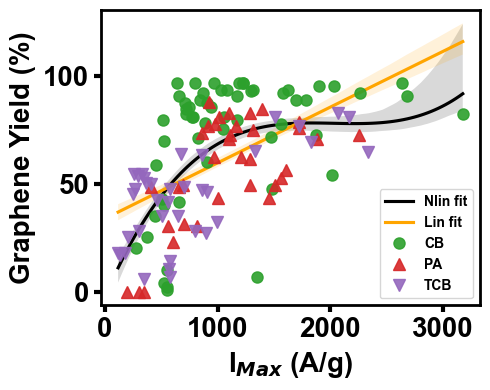

In [8]:
# relation of I_max and GY depend on material group. 
df_notMC = df.loc[df['Material'] !='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=3, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "red"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
#plt.legend(handles=[sns1, sns2])
#plt.legend(['Lin fit'])
#plt.legend(('Nlin fit', '', 'Lin fit'), loc='upper left')

groups = df_notMC.groupby(['Material'])

markers = ['o', '^', 'v']
colors=['blue', 'orange', 'green']

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    print (ax.artists)
    counter+=1
plt.legend(loc='lower right')

plt.xlabel(r'I$_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('Graphene Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(2) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_notMC.jpeg', dpi=500)
print (pearsonr(df_notMC['Norm_I_Max'], df_notMC['Graphene_Yield']))

PearsonRResult(statistic=0.2611109730168967, pvalue=0.08689789694650739)


/tmp/ipykernel_24334/3895307339.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


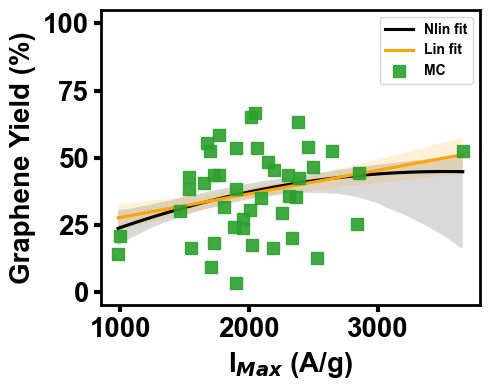

In [9]:
# relation of I_max and GY depend on material group. 
df_MC = df.loc[df['Material'] =='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=2, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
groups = df_MC.groupby(['Material'])

markers = ['s', ]
colors=['orange',]

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(loc='upper right')
plt.ylim(-5, 105)

plt.xlabel(r'I$_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('Graphene Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(2) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_MC.jpeg', dpi=500)
print (pearsonr(df_MC['Norm_I_Max'], df_MC['Graphene_Yield']))
#sns.lmplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', ci=0, order=1, hue="Material")
#plt.scatter (data=df_MC, x='Norm_I_Max', y='Graphene_Yield', hue='Material')#hue='Material')

In [10]:
# remove the outliers of crystallinity
df_crystallinity_outlier_rem = df.loc[df['TwoDtoG'] > 0.2].\
                               loc[df['FWHM_2D'] > 20].loc[df['FWHM_2D'] < 80]\
                               .loc[df['DtoG']>0.2]

In [11]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

[703.4397]


In [12]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [13]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [14]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

mean r2:  0.39343768318504124
mean pearson r:  0.681146697100142
coef_:  [ 0.02799216 -0.00923447 -0.01468558 -0.00401568  0.00645442  0.01214949
 -0.01634537 -0.01366349 -0.0077637 ]
Gamma score: 0.36805039583420474
r-squared 0.3313559143231488
mse:  0.02080728799348131
pearson r PearsonRResult(statistic=0.6660382422694052, pvalue=1.2596904780638452e-05)


Text(0, 0.5, 'Pred. I_Final/I_Max')

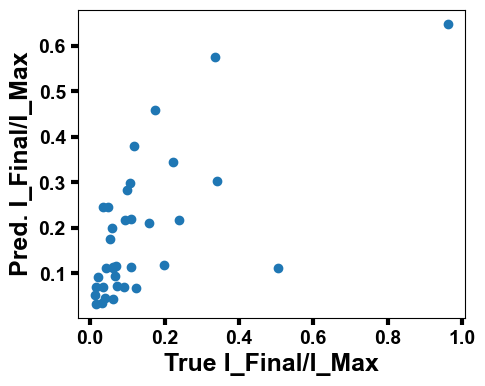

In [15]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 50):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.4, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_rand_state_split)

clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

mean r2:  0.5135462408568092
mean pearson r:  0.7684904007491176
coef_:  [ 0.00041989  0.00057522  0.00031471 -0.00130987 -0.02500137  0.00760197
  0.00567148 -0.00458045  0.01696405 -0.03295565  0.00319519]
Gamma score: 0.5142912264360037
r-squared 0.5564280374956868
mse:  275846.2600261805
pearson r PearsonRResult(statistic=0.7692655354083067, pvalue=6.684390251004333e-08)


Text(0, 0.5, 'Pred. Norm_I_Max')

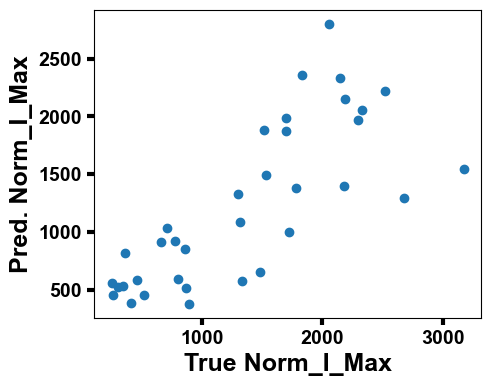

In [16]:
# Norm_I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Norm_I_Max = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

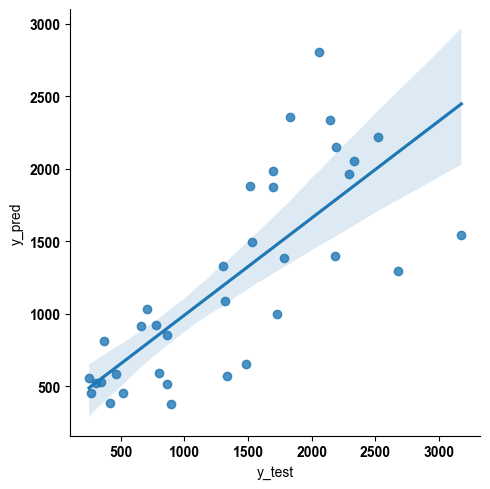

In [17]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')

mean r2:  0.47202452329404887
mean pearson r:  0.7531092951265675
Gamma score: 0.36760930082464693
r-squared 0.29479302985980327
mse:  626.111083645185
pearson r PearsonRResult(statistic=0.6523492201840502, pvalue=2.172746446079926e-05)


Text(0, 0.5, 'Pred. Norm_charge_tot')

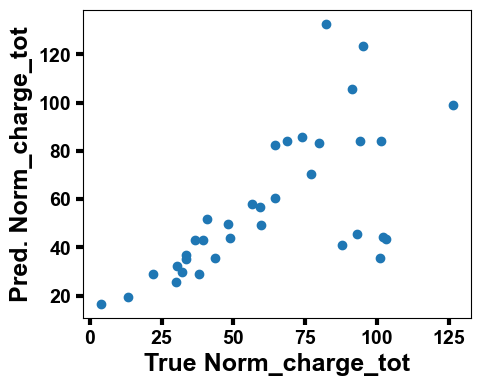

In [18]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
#CB_MC_PA_coef_Norm_charge_tot = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
#print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

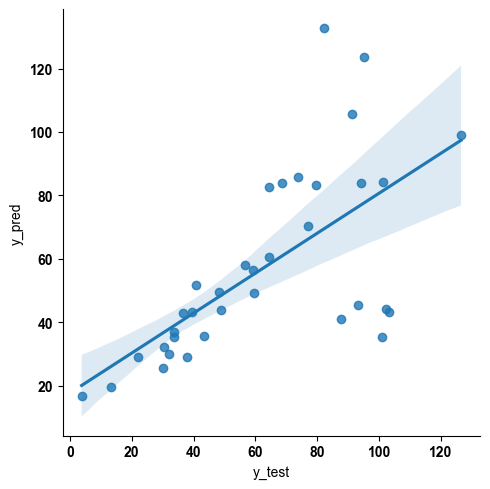

In [19]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')

In [20]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [80]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                       indices, test_size = 0.20, random_state=global_rand_state_split)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  2.79921574e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [77]:
global_rand_state_split

2571

In [72]:
idx_test

array([ 54, 146,  63,  55, 125, 100,   7, 155, 104,  89, 138, 143,   5,
        97, 163,  93,  33,  18,  61,  51,  66,  37,   4, 118,  60, 109,
       123, 139, 110, 159,  26,  56, 126,  45,   8])

In [22]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# to optimize the hyperparamters.
for random_state in range(20):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

#xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=global_rand_state_xgb)

xgbr_final_I_percent.fit(train_new_features, train_labels)

Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.8505407251334797
std of r pearson for test 0.024991902759004255 

Average of r_squared for test 0.5996683468755344
std of r_squared for test 0.043254139743709494 

Average of r_squared for train 0.7737213208336726
std of r_squared for train 0.008201266132600105
Mean Absolute Error: 0.2103 units.
r2 score =  0.7708437785703359
Mean Absolute Error: 0.1556 units.
r2 score =  0.65842413709924


PearsonRResult(statistic=0.8723277114308529, pvalue=8.705425526027189e-12)


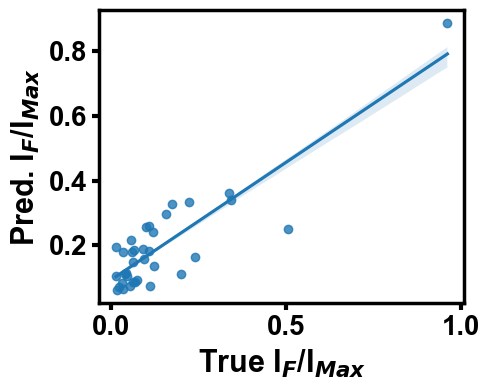

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Final_Current_Percent_test
data['y_true'] = test_labels
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_pred'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=20, order=1)

ax.set_ylabel('Pred. I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
#plt.yticks((0.1, 0.3, 0.5))
#plt.xticks((0.1, 0.5, 0.9))
plt.tight_layout()
plt.savefig('pred_IfinalImax.jpeg', dpi=500)
print (pearsonr(Final_Current_Percent_test, test_labels.ravel()))

In [24]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.06942016, 0.4768555, 0.0, 0.16809401, 0.0, 0.019567564, 0.05969975, 0.0, 0.206363]
Variable: charge_denisty Importance: ('charge_denisty', 0.07)
Variable: PulseTime Importance: ('PulseTime', 0.48)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.17)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_CB Importance: ('material_CB', 0.02)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.21)


In [25]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

PearsonRResult(statistic=0.7685462696680888, pvalue=6.995544989180821e-08)
Average of pearson r for test 0.7663782937070407
std of pearson 1 for test 0.00817909807797734 

Average of r_squared for test 0.41553491876086746
std of r_squared for test 0.012653218996029303 

Average of r_squared for train 0.7283146183815826
std of r_squared for train 0.006398469043333569
Mean Absolute Error: 720.2651 units.
r2 score =  0.6551466793046732
Mean Absolute Error: 821.3614 units.
r2 score =  0.4272059609473182


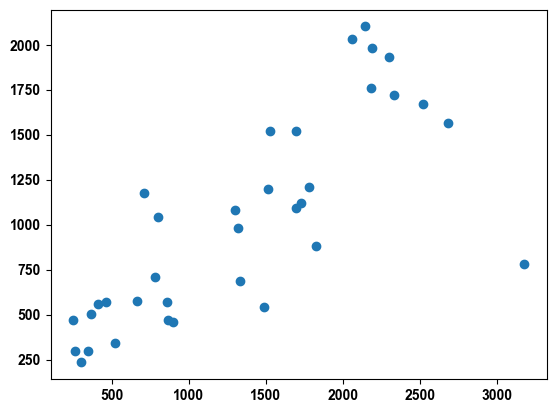

In [26]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=random_state)
    
    #xgbr_norm_I_max = RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_split=3)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=global_rand_state_xgb)
xgbr_norm_I_max.fit(train_new_features, train_labels);

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

#xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

PearsonRResult(statistic=0.77692957406503, pvalue=4.074234838877909e-08)


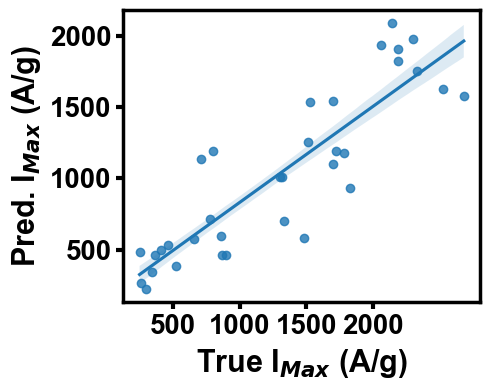

In [27]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_I_Max_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] < 3000]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=70, order=1)

ax.set_ylabel('Pred. I$_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True I$_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
plt.xticks((500, 1000, 1500, 2000))
plt.yticks((500, 1000, 1500, 2000))

plt.tight_layout()
plt.savefig('pred_norm_Imax.jpeg', dpi=500)
print (pearsonr(Norm_I_Max_test.ravel(), test_labels.ravel()))

In [28]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.09)
Variable: PulseTime Importance: ('PulseTime', 0.05)
Variable: material_CB Importance: ('material_CB', 0.02)
Variable: material_MC Importance: ('material_MC', 0.52)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.05)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.1)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.15)
[0.08680117, 0.045608558, 0.019841142, 0.52202225, 0.02938969, 0.049425133, 0.0, 0.10174772, 0.14516437]


In [29]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [30]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# used for hyperparamter tunning.
for random_state in range(4):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=random_state)
    #xgbr_norm_charge_total = RandomForestRegressor(max_depth=5, n_estimators=200, min_samples_split=3)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=global_rand_state_xgb)
xgbr_norm_charge_total.fit(train_new_features, train_labels)
#xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.8045886131697675
std of pearson 1 for test 0.01214023448708426 

Average of r_squared for test 0.6091829737755158
std of r_squared for test 0.02264973044150769 

Average of r_squared for train 0.999000573870169
std of r_squared for train 0.00025502577047091453
Mean Absolute Error: 34.054 units.
r2 score =  0.9293584115203855
Mean Absolute Error: 32.5416 units.
r2 score =  0.6372919452128065


PearsonRResult(statistic=0.8235746107887049, pvalue=1.2344609860394058e-09)


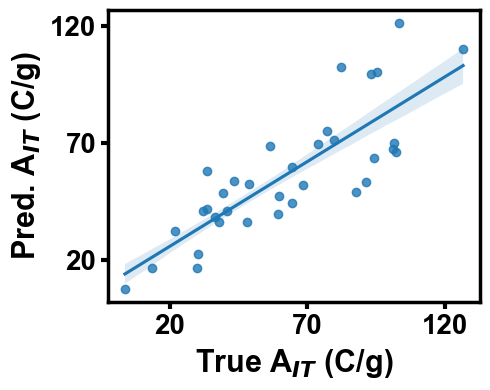

In [31]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_charge_tot_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=70, order=1)

ax.set_ylabel('Pred. A$_{IT}$ (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True A$_{IT}$ (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
plt.xticks((20, 70, 120))
plt.yticks((20, 70, 120))
plt.tight_layout()
plt.savefig('pred_norm_total_charge.jpeg', dpi=500)
print (pearsonr(Norm_charge_tot_test, test_labels.ravel()))

In [32]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.11)
Variable: PulseTime Importance: ('PulseTime', 0.13)
Variable: material_CB Importance: ('material_CB', 0.09)
Variable: material_MC Importance: ('material_MC', 0.24)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.19)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.02)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.05)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.13)
[0.10786366, 0.13400897, 0.09470267, 0.24119891, 0.02708825, 0.18575291, 0.022242479, 0.054635096, 0.13250704]


In [33]:
print (CB_MC_PA_coef_Final_Current_Percent)
print (CB_MC_PA_coef_Norm_I_Max)
print (CB_MC_PA_coef_Norm_charge_tot)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3
print (CB_MC_PA_TCB_coef_average)

[ 0.02799216 -0.00923447 -0.01468558 -0.00401568]
[ 0.00041989  0.00057522  0.00031471 -0.00130987]
[ 0.00682087 -0.00256791 -0.00440072  0.00016057]
[ 0.01174431 -0.00374239 -0.0062572  -0.00172166]


In [34]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                np.array (df['temp2']).reshape(-1, 1),
                                #y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                ), axis=1)

rand=global_rand_state_split
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                'material_sa',
                'material_sp2',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'physicsbased_model',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

In [35]:
len(feature_list)

18

In [36]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 173
MC_count 44 0.25 % of total 173
PA_count 35 0.2 % of total 173
TCB_count 37 0.21 % of total 173
CB count for testing 0.2% is 11.0
9
MC count for testing 0.2% is 9.0
9
PA count for testing 0.2% is 7.0
5
TCB count for testing 0.2% is 7.0
12


In [37]:
global_rand_state_split

2571

In [38]:
# focus on XGBoost, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_xgb = list()
r_squareds_xgb_randomized_testtrain = list()
r_squareds_xgb_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_xgb = list()

start = time.time()
r2_max = 0
test_split_seed1 = global_rand_state_split
test_split_seed2 = global_rand_state_split + 1
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #, stratify=df['Material']
                                       )
    r_squareds_xgb = list()
    r_squareds_xgb_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(0, 10):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=5, n_estimators=49, gamma=0.01, 
                   learning_rate=0.118, subsample=0.775, min_child_weight=6, 
                   random_state=random_state)
        """
        xgbr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_xgb.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_xgb.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_xgb_train.append(r_squared)

        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_xgb)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_xgb)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_xgb_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_xgb_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_xgb)
    r_squareds_xgb_randomized_testtrain.append (r_squareds_xgb)
    
print ('mean of RMSE for test: ', np.mean (RMSEs_xgb))
end = time.time()
r_squareds_xgb_randomized_testtrain_vec = np.array ((r_squareds_xgb_randomized_testtrain))
r_squareds_xgb_randomized_testtrain_mean = np.mean (r_squareds_xgb_randomized_testtrain_vec, axis=1)
r_squareds_xgb_randomized_testtrain_mean
#sns.displot (r_squareds_xgb_randomized_testtrain_vec)

r_squareds_xgb = r_squareds_xgb_randomized_testtrain_vec
print (np.mean(r_squareds_xgb_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_xgb_randomized_testtrain_vec)))

mean of RMSE for test:  11.430180211350022
0.7915988666900233
sd of random runs 0.016839787986475348


In [39]:
r_squareds_xgb_randomized_testtrain_vec

array([[0.76804574, 0.80450494, 0.79469392, 0.79530088, 0.80755996,
        0.80166468, 0.79472459, 0.81238709, 0.7578063 , 0.77930055]])

In [40]:
r_squareds_xgb

array([[0.76804574, 0.80450494, 0.79469392, 0.79530088, 0.80755996,
        0.80166468, 0.79472459, 0.81238709, 0.7578063 , 0.77930055]])

In [41]:
xgbr_graphyield.fit(new_features, Graphene_Yield)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.118, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=49, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=9, ...)

In [42]:
# focus on Random Forest, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_rf = list()
r_squareds_rf_randomized_testtrain = list()
r_squareds_rf_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_rf = list()
start = time.time()
r2_max = 0
test_split_seed1 = global_rand_state_split
test_split_seed2 = global_rand_state_split + 1
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       , stratify=df['Material']
                                       )
    r_squareds_rf = list()
    r_squareds_rf_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(0, 10):
        # Instantiate model with 1000 decision trees
        rf_graphyield = RandomForestRegressor(max_depth=4, n_estimators=20, 
                                              random_state=random_state, min_samples_split=5)
        """
        rf_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        rf_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = rf_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_rf.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_rf.append (r_squared)
    
        pred_train = rf_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_rf_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_rf)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_rf)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_rf_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_rf_train)))
    # train accuracy
    pred_train = rf_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = rf_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_rf)
    r_squareds_rf_randomized_testtrain.append (r_squareds_rf)

#m = tf.keras.metrics.RootMeanSquaredError()
#m.update_state(pred_test, test_labels)
#print ('RMSE for test, ', m.result().numpy())
end = time.time()
r_squareds_rf_randomized_testtrain_vec = np.array ((r_squareds_rf_randomized_testtrain))
r_squareds_rf_randomized_testtrain_mean = np.mean (r_squareds_rf_randomized_testtrain_vec, axis=1)
r_squareds_rf_randomized_testtrain_mean
#sns.displot (r_squareds_rf_randomized_testtrain_vec)

r_squareds_rf = r_squareds_rf_randomized_testtrain_vec
print (np.mean(r_squareds_rf_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_rf_randomized_testtrain_vec)))

/tmp/ipykernel_24334/55267219.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_24334/55267219.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_24334/55267219.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_24334/55267219.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykern

0.7576844045239658
sd of random runs 0.012322066342320658


/tmp/ipykernel_24334/55267219.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);


In [43]:
# focus on Linear Regression, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_lr = list()
r_squareds_lr_randomized_testtrain = list()
r_squareds_lr_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_lr = list()
start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 4
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       , stratify=df['Material']
                                       )
    r_squareds_lr = list()
    r_squareds_lr_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(45, 46):
        # Instantiate model with 1000 decision trees
        lr_graphyield = linear_model.LinearRegression()
        """
        lr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        lr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = lr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_lr.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_lr.append (r_squared)
    
        pred_train = lr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_lr_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_lr)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_lr)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_lr_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_lr_train)))
    # train accuracy
    pred_train = lr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = lr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_lr)
    r_squareds_lr_randomized_testtrain.append (r_squareds_lr)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
r_squareds_lr_randomized_testtrain_vec = np.array ((r_squareds_lr_randomized_testtrain))
r_squareds_lr_randomized_testtrain_mean = np.mean (r_squareds_lr_randomized_testtrain_vec, axis=1)
r_squareds_lr_randomized_testtrain_mean
#sns.displot (r_squareds_lr_randomized_testtrain_vec)

r_squareds_lr = r_squareds_lr_randomized_testtrain_vec
print (np.mean(r_squareds_lr_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_lr_randomized_testtrain_vec)))

RMSE for test,  14.842166
0.6534294436241866
sd of random runs 0.0796665897122674


2023-01-26 15:09:56.858606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:56.859044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:56.859388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:56.860133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:09:56.860499: I tensorflow/compiler/xla/stream_executo

In [44]:
# focus on BayesianRidge, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_br = list()
r_squareds_br_randomized_testtrain = list()
r_squareds_br_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_br = list()

start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 4
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       , stratify=df['Material']
                                       )
    r_squareds_br = list()
    r_squareds_br_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(45, 46):
        # Instantiate model with 1000 decision trees
        br_graphyield = linear_model.BayesianRidge(n_iter=1000, tol=1e-5)
        """
        br_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        br_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = br_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_br.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_br.append (r_squared)
    
        pred_train = br_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_br_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_br)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_br)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_br_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_br_train)))
    # train accuracy
    pred_train = br_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = br_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_br)
    r_squareds_br_randomized_testtrain.append (r_squareds_br)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
r_squareds_br_randomized_testtrain_vec = np.array ((r_squareds_br_randomized_testtrain))
r_squareds_br_randomized_testtrain_mean = np.mean (r_squareds_br_randomized_testtrain_vec, axis=1)
r_squareds_br_randomized_testtrain_mean
#sns.displot (r_squareds_br_randomized_testtrain_vec)

r_squareds_br = r_squareds_br_randomized_testtrain_vec
print (np.mean(r_squareds_br_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_br_randomized_testtrain_vec)))

RMSE for test,  15.997921
0.5874908450493578
sd of random runs 0.09688642623256345


/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed w

In [45]:
# focus on DecisionTreeRegressor, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_dt = list()
r_squareds_dt_randomized_testtrain = list()
r_squareds_dt_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_dt = list()
start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 4
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       , stratify=df['Material']
                                       )
    r_squareds_dt = list()
    r_squareds_dt_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(45, 46):
        # Instantiate model with 1000 decision trees
        dt_graphyield = DecisionTreeRegressor(max_depth=3, min_samples_split=3, random_state=random_state)
        """
        dt_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        dt_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = dt_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_dt.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_dt.append (r_squared)
    
        pred_train = dt_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_dt_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_dt)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_dt)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_dt_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_dt_train)))
    # train accuracy
    pred_train = dt_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = dt_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_dt)
    r_squareds_dt_randomized_testtrain.append (r_squareds_dt)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
r_squareds_dt_randomized_testtrain_vec = np.array ((r_squareds_dt_randomized_testtrain))
r_squareds_dt_randomized_testtrain_mean = np.mean (r_squareds_dt_randomized_testtrain_vec, axis=1)
r_squareds_dt_randomized_testtrain_mean
#sns.displot (r_squareds_dt_randomized_testtrain_vec)

r_squareds_dt = r_squareds_dt_randomized_testtrain_vec
print (np.mean(r_squareds_dt_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_dt_randomized_testtrain_vec)))

RMSE for test,  15.01844
0.6729917442223428
sd of random runs 0.060075703036986464


In [46]:
# focus on MLPRegressor, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_mlp = list()
r_squareds_mlp_randomized_testtrain = list()
r_squareds_mlp_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_mlp = list()
start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 4
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       , stratify=df['Material']
                                       )
    r_squareds_mlp = list()
    r_squareds_mlp_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(0, 2):
        # Instantiate model with 1000 decision trees
        mlp_graphyield = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', 
                   alpha=0.05, learning_rate = 'adaptive', solver='adam', random_state=random_state)
        """
        mlp_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        mlp_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = mlp_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_mlp.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_mlp.append (r_squared)
    
        pred_train = mlp_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_mlp_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_mlp)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_mlp)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_mlp_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_mlp_train)))
    # train accuracy
    pred_train = mlp_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = mlp_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_mlp)
    r_squareds_mlp_randomized_testtrain.append (r_squareds_mlp)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()

r_squareds_mlp_randomized_testtrain_vec = np.array ((r_squareds_mlp_randomized_testtrain))
r_squareds_mlp_randomized_testtrain_mean = np.mean (r_squareds_mlp_randomized_testtrain_vec, axis=1)
r_squareds_mlp_randomized_testtrain_mean
#sns.displot (r_squareds_mlp_randomized_testtrain_vec)

r_squareds_mlp = r_squareds_mlp_randomized_testtrain_vec
print (np.mean(r_squareds_mlp_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_mlp_randomized_testtrain_vec)))

/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stoch

RMSE for test,  18.640402
0.5382983155299443
sd of random runs 0.14576588049136066


/home/kianoosh/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


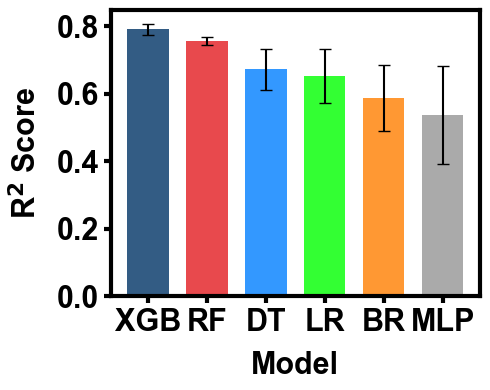

In [47]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'BR', 'MLP']
x_pos = np.arange(len(models))

# put the real numbers here
r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_mlp_mean, r2_br_mean = \
np.mean(r_squareds_xgb), np.mean(r_squareds_rf), np.mean(r_squareds_dt),\
np.mean(r_squareds_lr), np.mean(r_squareds_mlp), np.mean(r_squareds_br)               

r2_xgb_std, r2_rf_std, r2_dt_std, r2_br_std , r2_lr_std, r2_mlp_std = \
np.std(r_squareds_xgb), np.std(r_squareds_rf), np.std(r_squareds_dt),\
np.std(r_squareds_br), np.std(r_squareds_lr), np.std(r_squareds_mlp)


CTEs = [r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_br_mean, r2_mlp_mean]

error = [r2_xgb_std, r2_rf_std, r2_dt_std, r2_lr_std, r2_br_std, r2_mlp_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
plt.yticks(0.1*np.linspace(0, 8, 5, dtype=int))
ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')


ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.8, width=0.7,
       ecolor='black', 
       color= ('#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=4)

ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
plt.ylabel('R$^2$ Score', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)
[i.set_linewidth(3) for i in ax.spines.values()]
# Save the figure and show
#plt.yticks((0, 20, 40, 60, 80))
plt.tight_layout()
#

plt.savefig('error_bars_r2.jpeg', dpi=500)

In [48]:
r2_xgb_mean

0.7915988666900233

In [49]:
np.std(r_squareds_xgb)

0.016839787986475348

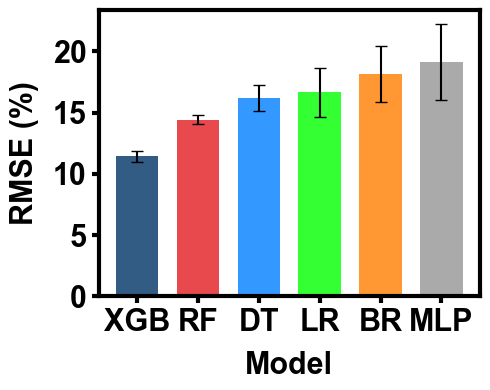

In [50]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'BR', 'MLP']
x_pos = np.arange(len(models))

# put the real numbers here
RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_br_mean, RMSE_lr_mean, RMSE_mlp_mean= \
np.mean(RMSEs_xgb), np.mean(RMSEs_rf), np.mean(RMSEs_dt),\
np.mean(RMSEs_br), np.mean(RMSEs_lr), np.mean(RMSEs_mlp) 

RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_br_std, RMSE_lr_std, RMSE_mlp_std = \
np.std(RMSEs_xgb), np.std(RMSEs_rf), np.std(RMSEs_dt),\
np.std(RMSEs_br), np.std(RMSEs_lr), np.std(RMSEs_mlp)  


CTEs = [RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_lr_mean, RMSE_br_mean, RMSE_mlp_mean]

error = [RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_lr_std, RMSE_br_std, RMSE_mlp_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.8, width=0.7,
       ecolor='black', 
       color= ('#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=4)

plt.yticks(np.linspace(0, 20, 5, dtype=int))
ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
plt.ylabel('RMSE (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
[i.set_linewidth(3) for i in ax.spines.values()]

ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.tight_layout()
plt.savefig('error_bars_RMSE.jpeg', dpi=500)
plt.show()

RMSE for test,  11.655085
time for 1 of split and 100 rep. is: 0.07365798950195312
r2 mean for test:  [0.78366106]
r2 mean for train:  0.9364511431247295


<AxesSubplot: ylabel='Count'>

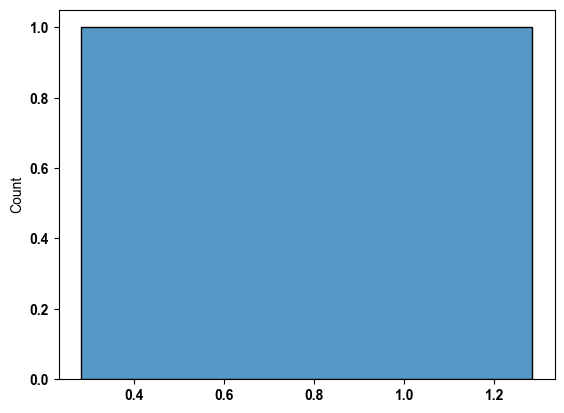

In [51]:
# one random sample from XGBoost: check the last printed r2 is good.
# 362 as random state reaches the best
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = global_rand_state_split
test_split_seed2 = global_rand_state_split + 1
test_split_count = test_split_seed2 - test_split_seed1
rep = 100
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #,stratify=df['Material']
                                       )
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(65, 66):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=5, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.775, min_child_weight=2, 
                   random_state=random_state)
        """
        xgbr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    #errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    r_squareds_randomized_testtrain.append (r_squareds)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
print ('time for {} of split and {} rep. is: {}'.format(test_split_count, rep, end-start))
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
print ('r2 mean for test: ', r_squareds_randomized_testtrain_mean)
print ('r2 mean for train: ', np.mean (r_squareds_train))
sns.histplot (r_squareds_randomized_testtrain_vec[0])

#print ('all r2: ', r_squareds_randomized_testtrain_vec)

In [52]:
error = abs(np.subtract(pred_test.reshape((-1, 1)), test_labels))
r2_score(np.delete(test_labels, 0), np.delete(pred_test, 0))

0.7861281824513232

In [53]:
pred_test.shape

(35,)

In [54]:
r_squareds_randomized_testtrain_vec

array([[0.78366106]])

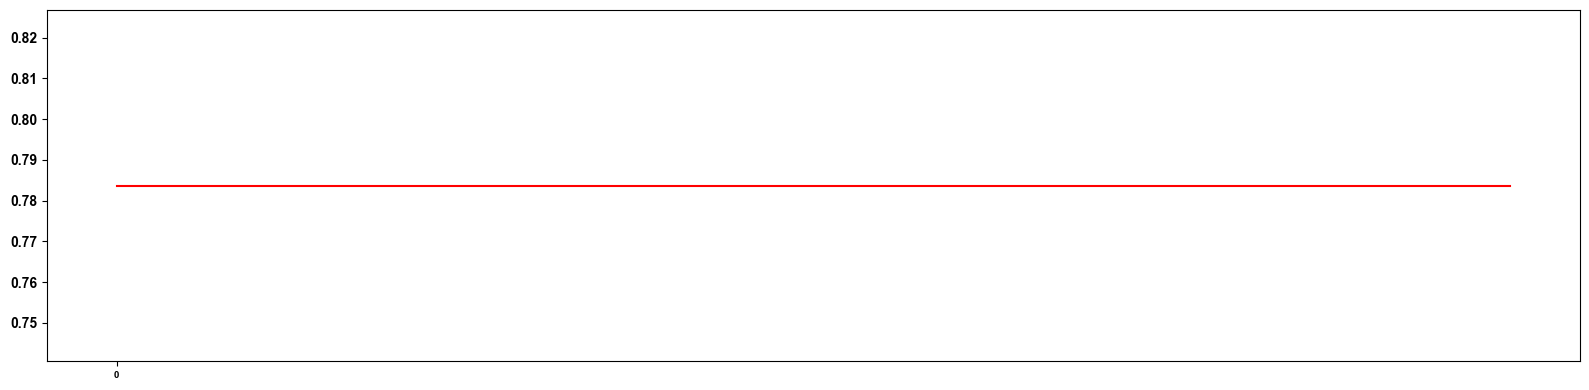

In [55]:
plt.subplots(figsize=(16, 4))
plt.plot (list(range(r_squareds_randomized_testtrain_vec[0].shape[0])), 
             r_squareds_randomized_testtrain_vec[0]);
xticks = list(range(0, r_squareds_randomized_testtrain_vec[0].shape[0], 1));
plt.plot([0, r_squareds_randomized_testtrain_vec[0].shape[0]], 
         [np.mean(r_squareds_randomized_testtrain_vec[0]), 
          np.mean(r_squareds_randomized_testtrain_vec[0])], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)

In [56]:
print ('r2 mean for train: ', np.mean (r_squareds_train))

r2 mean for train:  0.9364511431247295


In [57]:
print (np.mean(r_squareds_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_randomized_testtrain_vec)))

0.7836610596920144
sd of random runs 0.0


In [58]:
np.argmax(r_squareds_randomized_testtrain_vec)

0

In [59]:
r_squareds_randomized_testtrain_vec[0][np.argmax(r_squareds_randomized_testtrain_vec)]

0.7836610596920144

In [60]:
xgbr_graphyield.fit(train_new_features, train_labels);

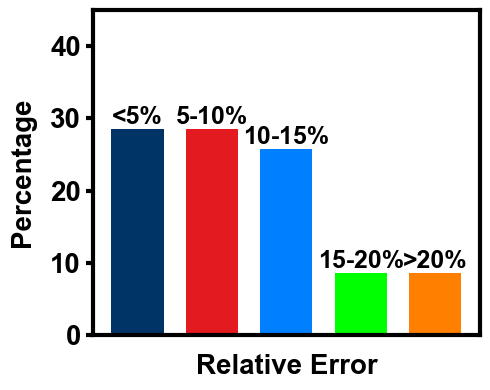

In [61]:
# make the numbers on axis bold
from matplotlib import rc, rcParams
error_group = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

abs_err = np.abs(pred_test.reshape(-1, 1)-test_labels.reshape(-1, 1))
less_5 = abs_err [abs_err <= 5]
larger_5 = abs_err [abs_err > 5]
larger_5_less_10 = larger_5 [larger_5 <= 10]
larger_10 = abs_err [abs_err > 10]
larger_10_less_15 = larger_10 [larger_10 <= 15]

larger_15 = abs_err [abs_err > 15]
larger_15_less_20 = larger_15 [larger_15 <= 20]
larger_20 = abs_err [abs_err > 20]
n_test = pred_test.shape[0]

#rc('font', weight='bold')
plt.close()
plt.figure(figsize = (5, 4))
frequencies = [less_5.shape[0]/n_test*100, larger_5_less_10.shape[0]/n_test*100, 
               larger_10_less_15.shape[0]/n_test*100, larger_15_less_20.shape[0]/n_test*100, 
               larger_20.shape[0]/n_test*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', width=0.7,
                      color = ['#003366', '#E31B20', '#007FFF', '#00FF00', '#FF7F00', '#959595'])

rects = ax.patches
x_labels = [ ]
labels = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

ax.tick_params(axis='x', direction='out', length=0, width=3, 
               colors='black', grid_alpha=0, labelsize='20')
ax.tick_params(axis='y', direction='out', length=5, width=3, 
               colors='black', grid_alpha=0, labelsize='20')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, fontsize = 18, fontweight='bold',
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0, 45)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.yticks(np.linspace(0, 40, 5), fontsize = 20)
plt.ylabel("Percentage", fontsize=20, fontweight='bold', fontname='Arial', labelpad=10)
plt.xlabel("Relative Error", fontsize=20, fontweight='bold', fontname='Arial', labelpad=10)
plt.tight_layout()
plt.savefig('err_dist.jpeg', dpi=500, bbox_inches='tight')

/tmp/ipykernel_24334/4220404596.py:20: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:
/tmp/ipykernel_24334/4220404596.py:55: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


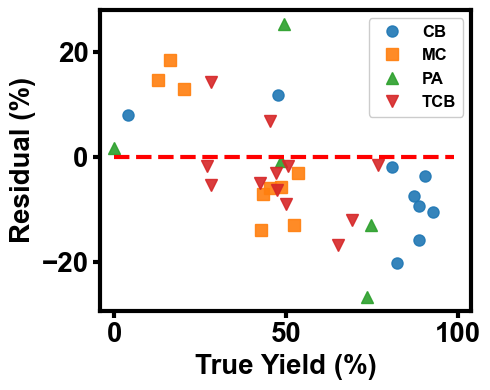

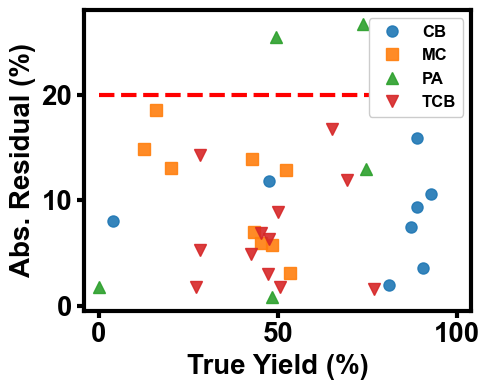

In [62]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1)
plt.xticks((0, 50, 100))
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xlim (-4, 104)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('resVSGY_test.jpeg', dpi=500)

pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1, loc='upper right')
plt.xlim (-4, 104)
x2 = list(range(0, 100))
y2 = np.repeat(20, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.yticks((0, 10, 20))
plt.xticks((0, 50, 100))
plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY_test.jpeg', dpi=500)

/tmp/ipykernel_24334/2633315224.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


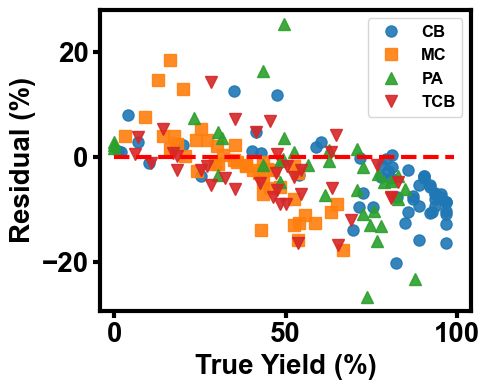

In [63]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.xlim (-4, 104)
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xticks((0, 50, 100))
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY.jpeg', dpi=500)

/tmp/ipykernel_24334/4248746353.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


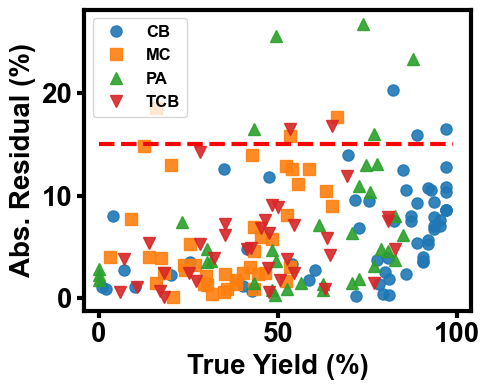

In [64]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = abs(predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.xlim (-4, 104)

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')

plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY.jpeg', dpi=500)

/tmp/ipykernel_24334/2633125660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = pred_test
/tmp/ipykernel_24334/2633125660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_true'] = test_labels
/tmp/ipykernel_24334/2633125660.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in gro

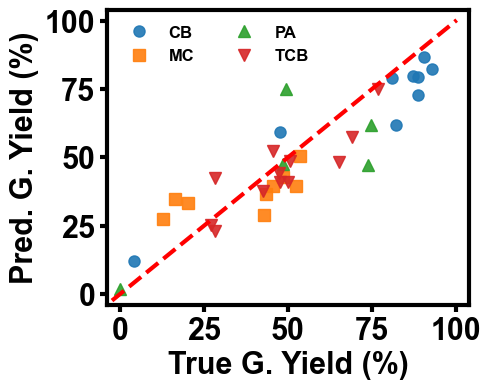

In [65]:
df_test = df.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_true, group.y_pred, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred. 2D/G
#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_ylabel('Pred. G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_xlabel('True G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_matg.jpeg', dpi=500)


In [66]:
df_test = df.loc[idx_test]

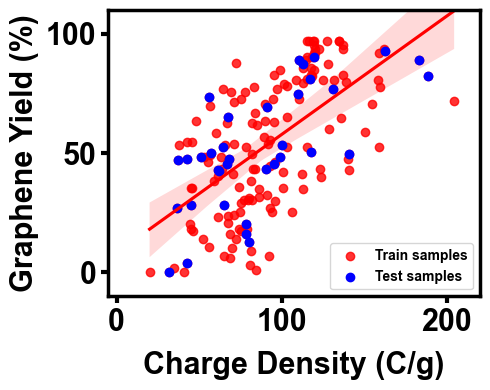

In [67]:
fig, ax = plt.subplots(figsize=(5, 4))

[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')

#plt.xticks((25, 50, 75, 100))
#plt.yticks((20, 45, 70, 95))
#plt.xlim(2,102)
#plt.ylim(15,98)

#plt.scatter (charge_denisty, Graphene_Yield, color='red', alpha=0.5, label='old exp.')
sns.regplot (data=df, x='charge_density', y='Graphene_Yield', color='red', 
             label='Train samples', ci=100)
plt.scatter (df_test['Voltage']*df_test['Cap']/df_test['Mass'], 
             df_test['Graphene_Yield'], color='blue', alpha=1, label='Test samples')

"""
plt.scatter (df['charge_density'], 
             df['Graphene_Yield'], color='blue', alpha=0.5, label='Train samples')
"""

#plt.scatter (charge_density_test, Graphene_Yield_test, color='black', marker='*', label='new exp.')
#plt.scatter (charge_density_test, graphene_yield_test_predicted, color='blue', marker='s', label='new pred. exp.')

ax.set_xlabel('Charge Density (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('Graphene Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
plt.legend(loc='lower right')
plt.xticks([0, 100, 200])
plt.xlim(-5, 220)
plt.ylim(-10, 110)
plt.tight_layout()
plt.savefig('GY_CV_oldVSnew_exp.jpeg', dpi=500)

In [68]:
r2_score(test_labels, pred_test)

0.7836610596920144

/tmp/ipykernel_24334/4097771022.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


AttributeError: 'DataFrame' object has no attribute 'y_true'

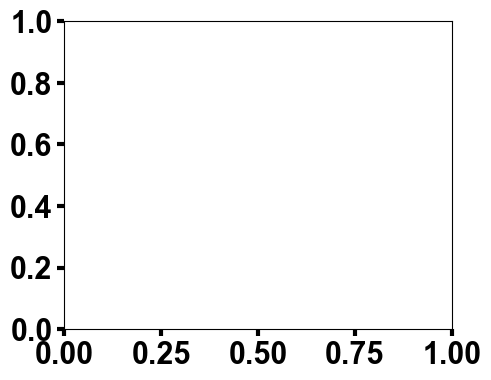

In [69]:
# Distribution of Graphene_yield with  CD density groups
cd = np.array (df_test['charge_density'])
Qs = np.quantile (cd, [0.25, 0.5, 0.75])

cd_class = cd
cd_class = np.where(cd <= Qs[0], 0, cd_class)
cd_class = np.where((cd > Qs[0]) & (cd <= Qs[1]), 1, cd_class)
cd_class = np.where((cd > Qs[1]) & (cd <= Qs[2]), 2, cd_class)
cd_class = np.where(cd > Qs[2], 3, cd_class)

# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cd_class'] = cd_class
groups = df_test.groupby(['cd_class'])

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
counter=0
markers = ['1', '*', '^', 'o']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_true, group.y_pred,  marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred. 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_xlabel('True Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(('CD ≤ {}'.format(int(Qs[0])), 
           '{} < CD ≤ {}'.format (int(Qs[0]), int(Qs[1])), 
                                  '{} < CD ≤ {}'.format (int(Qs[1]), int(Qs[2])), 
                                                         'CD > {}'.format(int(Qs[2])) ), 
                                  frameon=False, ncol=1, fontsize=12, loc='upper left')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))
# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cdgroup.jpeg', dpi=300)

In [ ]:
# find the outlier of the tested model
test_error = abs(pred_test.reshape(pred_test.shape[0], 1)-test_labels)
plt.scatter(test_labels, test_error)

error_99quan = np.quantile(test_error, 0.99)
error_99quan_index = np.where (test_error > error_99quan)[0] 
print (test_labels[error_99quan_index])
print (test_new_features[error_99quan_index])

r_squared_test = r2_score(test_labels, pred_test)
print('r2 score before removal= ', r_squared_test)

r_squared_test = r2_score(np.delete (test_labels, error_99quan_index), 
                          np.delete (pred_test, error_99quan_index))
print('r2 score 99% outlier removed= ', r_squared_test)

In [ ]:
# the higher the pulsetime, the lower the Final current percentage
plt.scatter(pulsetime, Final_Current_Percent_predicted)
plt.xlabel ('pulsetime')
plt.ylabel ('Final current percentage')

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )

Final_Current_Percent_predicted_ = Final_Current_Percent_predicted.reshape(
                                   Final_Current_Percent_predicted.shape[0], )

pearsonr(pulsetime_, Final_Current_Percent_predicted_)

In [ ]:
plt.scatter(pulsetime, Norm_I_Max_predicted)
plt.xlabel ('pulsetime')
plt.ylabel ('Norm_I_Max_predicted')

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_I_Max_predicted_ = Norm_I_Max_predicted.reshape(
                                   Norm_I_Max_predicted.shape[0], )

pearsonr(pulsetime_, Norm_I_Max_predicted_)

In [ ]:
# the higher the pulse time, the higher total charge
plt.scatter(pulsetime, Norm_charge_tot_predicted)

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_charge_tot_predicted_ = Norm_charge_tot_predicted.reshape(
                                   Norm_charge_tot_predicted.shape[0], )

pearsonr(pulsetime_, Norm_charge_tot_predicted_)

In [ ]:
# Get numerical feature importances
importances = list(xgbr_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

In [ ]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test= abs(pred_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')
# Plot predictions vs True values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Pred. 2D/G
plt.plot(pred_test, test_labels, 
         linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('True', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred.', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

In [ ]:
def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of I Max", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot


# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
df_test = pd.read_csv('FJH_ML_Final.csv', header=1)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df_test)
df_test['Norm_I_Max'] = norm1
df_test['Norm_charge_tot'] = norm2
df_test['charge_density'] = df_test['Voltage']*df_test['Cap']/df_test['Mass']
# df_test['test_feature'] = (df_test['Voltage']/df_test['Mass'])#*df_test['PulseTime']
# df_test = df_test[df_test['TwoDtoG']<1.5]
# df_test = df_test[df_test['Graphene_Yield']>20]

# Cut dataframe to only the test set
df_test = df_test.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

groups = df_test.groupby(['Material'])

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot( group.y_true, group.y_pred, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred. 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_materialgroup.jpeg', dpi=300)
plt.show()

In [ ]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred.ted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Pred. Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('True Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.jpeg', dpi=300)
plt.show()

In [ ]:
# !!! try also regular coloring not by groups
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')


for name, group in groups:
    p = ax.scatter(group.y_true, group.y_pred,  c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Pred. Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('True Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('XGB_Regression_Performance_colorChargeDensity.jpeg', dpi=300)
plt.show()

In [ ]:
# outside test (Need to ask Jacob the details, material, atmosphere)
filename = 'FJH_ML_MBO_Yield4_modified.csv'
df_testBO0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
df_testBO = df_testBO0

# Only works for test that are TCB material !!!!!!
Material_CB_testBO = np.array (df_testBO['Material']).reshape(-1, 1)
Material_CB_testBO [:] = 0
Material_MC_testBO = np.zeros_like (Material_CB_testBO)
Material_PA_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO [:] = 1
material_type_testBO = np.concatenate ((Material_CB_testBO, 
                                        Material_MC_testBO, 
                                        Material_PA_testBO,
                                        Material_TCB_testBO), axis=1)
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_testBO = material_type_testBO * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
Atmosphere_air_testBO = np.array (df_testBO['Atmosphere']).reshape(-1, 1)
Atmosphere_air_testBO [:] = 0
Atmosphere_arg_testBO = np.zeros_like (Atmosphere_air_testBO)
atmosphere_type_testBO = np.concatenate ((Atmosphere_air_testBO, 
                                          Atmosphere_arg_testBO ), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_testBO['Cap'] = 60 + df_testBO['Cap']*18
charge_density_testBO = np.array (df_testBO['Voltage']*df_testBO['Cap']/
                                  df_testBO['Mass']).reshape(-1, 1)
pulsetime_testBO = np.array (df_testBO['PulseTime']).reshape(-1, 1)
Pretreat_voltage_testBO = np.array (df_testBO['Pretreat_voltage']).reshape(-1, 1)
voltage_testBO = np.array (df_testBO['Voltage']).reshape(-1, 1)
mass_testBO = np.array (df_testBO['Mass']).reshape(-1, 1)
Graphene_Yield_testBO = 100*np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)

In [ ]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_testBO = material_type_testBO*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_I_Finalperc_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Final_Current_Percent_predicted_testBO = xgbr_final_I_percent.predict(features_testBO)

# 2) norm_I_Max prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_I_Max_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_I_Max_predicted_testBO = xgbr_norm_I_max.predict(features_testBO)

# 3) norm_Charge_total
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_charge_Tot_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_charge_tot_testBO = xgbr_norm_charge_total.predict(features_testBO)

In [ ]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_BO = np.matmul(material_type_testBO, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_testBO['Voltage']**1)*
                                  ((df_testBO['Mass']/100)**-1)*
                                  (df_testBO['Cap']**1))**1*1e-9).reshape(-1, 1),
                                  ((np.array(df_testBO['Pretreat_voltage'])**1)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_testBO.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_testBO['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_testBO.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_testBO['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_testBO['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                  ), axis=1)
phys_pred_BO = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_testBO, phys_pred_BO)

In [ ]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_BO = np.matmul(material_type_testBO, CB_MC_PA_TCB_res)
heat_power_BO = np.array (df_testBO['Voltage']*df_testBO['Voltage']/
                          resistance_matrix_BO*df_testBO['PulseTime']*(1e-6)).reshape(-1, 1)

features_testBO = np.concatenate ((charge_density_testBO,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                   material_type_GY_coef_testBO,
                                   pulsetime_testBO,
                                   Pretreat_voltage_testBO,
                                   phys_pred_BO.reshape(-1, 1),
                                   atmosphere_type_testBO,
                                   Final_Current_Percent_predicted_testBO.reshape(-1, 1),
                                   Norm_I_Max_predicted_testBO.reshape(-1, 1),
                                   Norm_charge_tot_testBO.reshape(-1, 1),
                                   heat_power_BO
                                  ), axis=1)

In [ ]:
graphene_yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)
graphene_yield_testBO = 100*graphene_yield_testBO
graphene_yield_testBO_predicted = xgbr_graphyield.predict (features_testBO)

print ('R-squared: ', r2_score(graphene_yield_testBO, graphene_yield_testBO_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_testBO, graphene_yield_testBO_predicted)))

In [ ]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Pred. Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('True Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_testBO_predicted, graphene_yield_testBO, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testBOsamples.jpeg', dpi=300)
plt.show()

In [ ]:
# Future experimental trial: call it newexp
filename = 'New_experimental_trial_modified_lucas.csv'
df_newexp0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=0)
df_newexp = df_newexp0.copy()

# the prediction range should cover a large range
#df_newexp['Voltage'] = df_newexp0 ['Voltage'] - 20
#df_newexp['Mass'] = df_newexp0 ['Mass'] + 20

# Only works for test that are TCB material !!!!!!
material_type_newexp = np.asarray (df_newexp.loc[:, ('CB_per', 'MC_per', 'PA_per', 'TCB_per')])
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_newexp = material_type_newexp * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
atmos_dummies = pd.get_dummies(df_newexp['Atmosphere_type'])
atmosphere_type_newexp = np.concatenate ((np.array(atmos_dummies['air']).reshape(-1, 1), 
                                          np.array(atmos_dummies['arg']).reshape(-1, 1)), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_newexp['Cap'] = df_newexp['Cap']
charge_density_newexp = np.array (df_newexp['Voltage']*df_newexp['Cap']/
                                  df_newexp['Mass']).reshape(-1, 1)
pulsetime_newexp = np.array (df_newexp['PulseTime']).reshape(-1, 1)
Pretreat_voltage_newexp = np.array (df_newexp['Pretreat_voltage']).reshape(-1, 1)
voltage_newexp = np.array (df_newexp['Voltage']).reshape(-1, 1)
mass_newexp = np.array (df_newexp['Mass']).reshape(-1, 1)
Graphene_Yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)

In [ ]:
material_type_GY_coef_newexp

In [ ]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_newexp = material_type_newexp*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_I_Finalperc_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Final_Current_Percent_predicted_newexp = xgbr_final_I_percent.predict(features_newexp)

# 2) norm_I_Max prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_I_Max_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_I_Max_predicted_newexp = xgbr_norm_I_max.predict(features_newexp)

# 3) norm_Charge_total
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_charge_Tot_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_charge_tot_newexp = xgbr_norm_charge_total.predict(features_newexp)

In [ ]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp = np.matmul(material_type_newexp, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_newexp['Voltage']**1)*
                                  ((df_newexp['Mass']/100)**-1)*
                                  (df_newexp['Cap']**1))**1*1e-9).reshape(-1, 1),
                                  ((np.array(df_newexp['Pretreat_voltage'])**0.5)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_newexp.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_newexp['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_newexp.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_newexp['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_newexp['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                  ), axis=1)
phys_pred_newexp = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_newexp, phys_pred_newexp)

In [ ]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_newexp = np.matmul(material_type_newexp, CB_MC_PA_TCB_res)
heat_power_newexp = np.array (df_newexp['Voltage']*df_newexp['Voltage']/
                          resistance_matrix_newexp*df_newexp['PulseTime']*(1e-6)).reshape(-1, 1)

features_newexp = np.concatenate ((charge_density_newexp,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                   material_type_GY_coef_newexp,
                                   pulsetime_newexp,
                                   Pretreat_voltage_newexp,
                                   phys_pred_newexp.reshape(-1, 1),
                                   atmosphere_type_newexp,
                                   Final_Current_Percent_predicted_newexp.reshape(-1, 1),
                                   Norm_I_Max_predicted_newexp.reshape(-1, 1),
                                   Norm_charge_tot_newexp.reshape(-1, 1),
                                   heat_power_newexp
                                  ), axis=1)

In [ ]:
graphene_yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)
graphene_yield_newexp = graphene_yield_newexp
graphene_yield_newexp_predicted = xgbr_graphyield.predict (features_newexp)

print ('R-squared: ', r2_score(graphene_yield_newexp, graphene_yield_newexp_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_newexp, graphene_yield_newexp_predicted)))

In [ ]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Pred. Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('True Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_newexp_predicted, graphene_yield_newexp, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_newexpsamples.jpeg', dpi=300)
plt.show()

In [ ]:
df_newexp['mlpred_Graphene_Yield'] = graphene_yield_newexp_predicted
df_newexp

In [ ]:
print ('min of pred GY', np.min (df_newexp['mlpred_Graphene_Yield']))
print ('max of pred GY', np.max (df_newexp['mlpred_Graphene_Yield']))
sns.distplot (df_newexp['mlpred_Graphene_Yield'])
sns.distplot (df_newexp['Average_Graphene_Yield'])

In [ ]:
print (np.min (df_newexp['Average_Graphene_Yield']))
print (np.max (df_newexp['Average_Graphene_Yield']))

In [ ]:
print (np.min (df_newexp['mlpred_Graphene_Yield']))
print (np.max (df_newexp['mlpred_Graphene_Yield']))

In [ ]:
sns.histplot (df_newexp['mlpred_Graphene_Yield'])

In [ ]:
df_newexp

In [ ]:
print (pearsonr (df_newexp['Voltage'], df_newexp['mlpred_Graphene_Yield']))
plt.scatter (df_newexp['Voltage'], df_newexp['mlpred_Graphene_Yield'])

In [ ]:
print (r2_score (df_newexp['Average_Graphene_Yield'], df_newexp['mlpred_Graphene_Yield']))

In [ ]:
df_newexp = df_newexp.sort_values(by=['Sample'])

In [ ]:
df_newexp_noGY = (df_newexp.iloc[:, 0:11]).copy()
df_newexp_noGY.to_csv('New experiments of FJH to test modelv3.csv', index=False)

In [ ]:
print ('End!!!')